In [1]:
__author__ = 'tkurth'
import sys
import os
import numpy as np
import pandas as pd
import h5py
from matplotlib import pyplot as plt
import matplotlib.mlab as mlab
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from nbfinder import NotebookFinder
sys.meta_path.append(NotebookFinder())
%matplotlib inline
import time
from tqdm import tqdm
import re
import pickle

/global/common/cori/software/python/2.7-anaconda/envs/deeplearning/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load Data

In [2]:
#retrieve files
directory="/global/cscratch1/sd/tkurth/atlas_dl/atlas_caffe/runs_preselect_augmented_improved"
filelist=[x for x in os.listdir(directory) if x.startswith('output')]

## Populate Arrays

In [3]:
datalist=[]

for fname in tqdm(filelist):
    
    #determine chunkid:
    chunkid=int(re.match(r'output_chunk(.*?).h5',fname).groups()[0])
    
    #print "Open file "+fname
    f = h5py.File(directory+'/'+fname,'r')
    
    tmpdata={}
    for item in f.items():
        
        #determine name and ID of item
        itemname=item[0].split('_')[0]
        itemid=int(item[0].split('_')[1])
        
        #read data
        data=list(f[item[0]].value)
        
        #add to dictionary
        if (chunkid,itemid) not in tmpdata.keys():
            tmpdata[(chunkid,itemid)]={itemname: data}
        else:
            tmpdata[(chunkid,itemid)][itemname]=data
    
    #close the file
    f.close()
    
    #put in list:
    for item in tmpdata:
        dct=tmpdata[item].copy()
        dct['chunk_id']=item[0]
        dct['item_id']=item[1]
        datalist.append(dct)

100%|██████████| 64/64 [01:28<00:00,  1.16s/it]


In [4]:
#Convert to stacked array:
l_data=[]
p_data=[]
w_data=[]
c_data=[]
for item in datalist:
    p_data+=[x[1] for x in item['softmax']]
    l_data+=item['label']
    w_data+=item['weight']
    c_data+=item['psr']

## ROC

In [5]:
#compute ROC from data
fpr, tpr, thresholds = metrics.roc_curve(l_data, p_data, pos_label=1, sample_weight=w_data)
fpr_cut, tpr_cut, thresholds = metrics.roc_curve(l_data, c_data, pos_label=1, sample_weight=w_data)
fpr_cut=fpr_cut[1]
tpr_cut=tpr_cut[1]

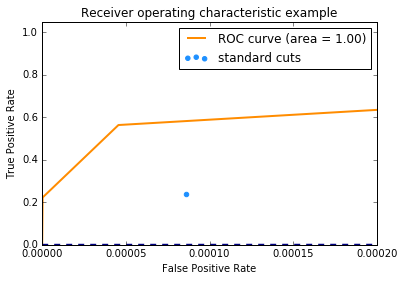

In [6]:
#plot the data
plt.figure()
lw = 2
#full curve
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr,reorder=True))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.scatter([fpr_cut],[tpr_cut], color='dodgerblue', label='standard cuts')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.savefig('plots/ROC_1400_850.png',dpi=300)

#zoomed-in
#plt.plot(fpr, tpr, color='darkorange',
#         lw=lw, label='ROC curve (area = %0.2f)' % metrics.auc(fpr,tpr))
#plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 0.0002])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="upper right")
plt.savefig('plots/ROC_1400_850_zoom.png',dpi=300)
plt.show()

# CNN results

In [ ]:
#threshold
threshold=0.999

In [ ]:
#compute signal efficiency:
total_signal=np.sum(l_data)
found_signal=np.sum([1. if x[0]*x[1]>threshold else 0. for x in zip(l_data,p_data)])
print 'sig-efficiency(CNN): ',found_signal/total_signal
print 'sig-survivors(CNN): ',found_signal

#compute bg rejection:
total_background=np.sum([1.-x for x in l_data])
false_positive_bg=np.sum([1. if (1.-x[0])*x[1]>threshold else 0. for x in zip(l_data,p_data)])
print 'bg-rejection(CNN): ',1.-false_positive_bg/total_background
print 'bg-survivors(CNN): ',(1.-(1.-false_positive_bg/total_background))*total_background

In [ ]:
#AMS
#compute s:
sval=np.sum([x[2] if x[0]*x[1]>threshold else 0. for x in zip(l_data,p_data,w_data)])
bval=np.sum([x[2] if (1.-x[0])*x[1]>threshold else 0. for x in zip(l_data,p_data,w_data)])
brval=10.

#print AMS results
print "AMS(CNN) = ",np.sqrt(2.*((sval+bval+brval)*np.log(1.+sval/(bval+brval))-sval))

# Cut-based results

In [ ]:
#compute signal efficiency:
total_signal=np.sum(l_data)
found_signal=np.sum([1. if x[0]*x[1]>0. else 0. for x in zip(l_data,c_data)])
print 'sig-efficiency(CUT): ',found_signal/total_signal
print 'sig-survivors(CUT): ',found_signal

#compute bg rejection:
total_background=np.sum([1.-x for x in l_data])
false_positive_bg=np.sum([1. if (1.-x[0])*x[1]>0. else 0. for x in zip(l_data,c_data)])
print 'bg-rejection(CUT): ',1.-false_positive_bg/total_background
print 'bg-survivors(CUT): ',(1.-(1.-false_positive_bg/total_background))*total_background

In [ ]:
#AMS
#compute s:
sval=np.sum([x[2] if x[0]*x[1]>threshold else 0. for x in zip(l_data,c_data,w_data)])
bval=np.sum([x[2] if (1.-x[0])*x[1]>threshold else 0. for x in zip(l_data,c_data,w_data)])
brval=10.

#print AMS results
print "AMS(CUT) = ",np.sqrt(2.*((sval+bval+brval)*np.log(1.+sval/(bval+brval))-sval))